/var/folders/h8/w67nqb354zs8z6vhf7rby50m0000gn/T/ipykernel_75037/2777762825.py:16: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:


Using device: mps


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


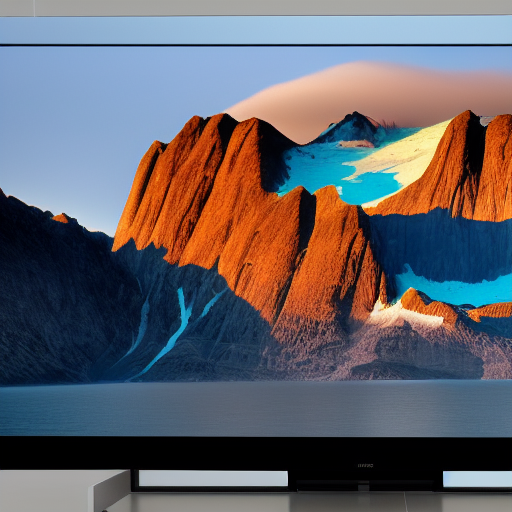

In [7]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

# DEVICE = "cpu"
DEVICE = "mps"

ALLOW_CUDA = False
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
# prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "8k resolution"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.2

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50#50
seed = None#42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [ ]:
class DataLoader(torch.utils.data.DataLoader):
    r"""Data loader which merges data objects from a
    :class:`torch_geometric.data.dataset` to a mini-batch.

    Args:
        dataset (Dataset): The dataset from which to load the data.
        batch_size (int, optional): How many samples per batch to load.
            (default: :obj:`1`)
        shuffle (bool, optional): If set to :obj:`True`, the data will be
            reshuffled at every epoch. (default: :obj:`False`)
        follow_batch (list or tuple, optional): Creates assignment batch
            vectors for each key in the list. (default: :obj:`[]`)
    """
    def __init__(self, dataset, batch_size=1, shuffle=False, follow_batch=[],
                 **kwargs):
        def collate(batch):
            elem = batch[0]
            if isinstance(elem, Data):
                return Batch.from_data_list(batch, follow_batch)
            elif isinstance(elem, float):
                return torch.tensor(batch, dtype=torch.float)
            elif isinstance(elem, int_classes):
                return torch.tensor(batch)
            elif isinstance(elem, string_classes):
                return batch
            elif isinstance(elem, container_abcs.Mapping):
                return {key: collate([d[key] for d in batch]) for key in elem}
            elif isinstance(elem, tuple) and hasattr(elem, '_fields'):
                return type(elem)(*(collate(s) for s in zip(*batch)))
            elif isinstance(elem, container_abcs.Sequence):
                return [collate(s) for s in zip(*batch)]

            raise TypeError('DataLoader found invalid type: {}'.format(
                type(elem)))

        super(DataLoader,
              self).__init__(dataset, batch_size, shuffle,
                             collate_fn=lambda batch: collate(batch), **kwargs)
device = 'mps'
model.to(device).reset_parameters()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


train_dataset,train_des, test_dataset, test_des = [],[],[],[]
for index, d in enumerate(dataset):
    if d.set=='train':
        des = (torch.tensor(netlsd.heat(to_networkx(d, to_undirected = True)))*0.1).float()
        des_d = Data(x = des, edge_index = d.edge_index, y = d.y)
        train_dataset.append(d)
        train_des.append(des_d)

torch.save(train_des,dataset_name+'_netlsd_train.pt')

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
train_loader_des = DataLoader(train_des, batch_size=128, shuffle=False)

def train_FEGIN(model, optimizer, loader,des_loader, device):
    model.train()

    total_loss = 0
    for data,des in zip(loader,des_loader):
        optimizer.zero_grad()
        data = data.to(device)
        des = des.to(device)
        out = model(data,des)
        
    return out

In [5]:
!pwd

/Users/yuxuanli/Desktop/circuit_design/pytorch-stable-diffusion-main/sd


In [3]:
def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

/Users/yuxuanli/Desktop/circuit_design/pytorch-stable-diffusion-main/sd


In [11]:
import numpy as np
device='mps'
WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8
latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)
# input_image = None
generator = torch.Generator(device=device)
generator.seed()
encoder = models["encoder"]
encoder.to(device)
            
image_path = "./images/dog.jpg"
input_image = Image.open(image_path)
input_image_tensor = input_image.resize((WIDTH, HEIGHT))
input_image_tensor = np.array(input_image_tensor)
input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32)
input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
input_image_tensor = input_image_tensor.unsqueeze(0)
input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)
encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
print('input_image_tensor', input_image_tensor.size())
print('encoder_noise', encoder_noise.size())
latents = encoder(input_image_tensor, encoder_noise)

print(input_image_tensor.size())

In [3]:
!pwd

/Users/yuxuanli/Desktop/circuit_design/pytorch-stable-diffusion-main/sd


In [30]:
latents_shape = (1, 3, LATENTS_HEIGHT, LATENTS_WIDTH)
input_image_tensor = torch.randn((1, 3, 512, 512), generator=generator, device=device)

encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
print('input_image_tensor', input_image_tensor.size())
print('encoder_noise', encoder_noise.size())
latents = encoder(input_image_tensor, encoder_noise)

print(input_image_tensor.size())

Image-before (1212, 1106)
Image-after-rescale (512, 512)
input_image_tensor-4 786432
******************** 512
******************** 512
******************** 3
******************** 172
input_image_tensor-3 torch.Size([512, 512, 3])
input_image_tensor-2 torch.Size([512, 512, 3])
input_image_tensor-1 torch.Size([1, 512, 512, 3])
input_image_tensor torch.Size([1, 3, 512, 512])
encoder_noise torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64]) torch.Size([1, 4, 64, 64])
latents-end torch.Size([1, 4, 64, 64])
torch.Size([1, 3, 512, 512])


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from decoder import VAE_AttentionBlock, VAE_ResidualBlock

class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 256), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 512), 
            
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            nn.Conv2d(512, 8, kernel_size=3, padding=1), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0), 
        )

    def forward(self, x, noise):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))
            
            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        print(x.size())
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8. 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt()
        
        # Transform N(0, 1) -> N(mean, stdev) 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        print('*********************')
        # print(mean.size(),stdev.size(),noise.size())
        # print(mean.size())
        # print(stdev.size())
        # print(noise.size())
        x = mean + stdev * noise
        
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        
        return x
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
import model_converter
ckpt_path = "./data/v1-5-pruned-emaonly.ckpt"
device = 'mps'
# from encoder import VAE_Encoder
state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

encoder = VAE_Encoder().to(device)
encoder.load_state_dict(state_dict['encoder'], strict=True)
# latents_shape = (1, 3, LATENTS_HEIGHT, LATENTS_WIDTH)
input_image_tensor = torch.randn((1, 3, 512, 512), generator=generator, device=device)
encoder_noise = torch.randn((1, 3, 512, 512), generator=generator, device=device)

encoder(input_image_tensor, encoder_noise)
print(encoder.mean)

In [14]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

x torch.Size([1, 8, 64, 64])
*********************
mean torch.Size([1, 4, 64, 64])
stdev torch.Size([1, 4, 64, 64])
noise torch.Size([1, 4, 64, 64])


tensor([[[[-1.4864, -0.9815, -0.9484,  ..., -0.0782, -0.3435,  0.3140],
          [-0.2818, -0.8840, -1.8635,  ..., -1.5010, -1.5107,  0.1602],
          [-1.7077, -0.2086, -0.1513,  ..., -1.7995, -0.0250, -0.4913],
          ...,
          [-0.2084, -1.4657, -0.7528,  ..., -1.5601, -1.0433, -1.7112],
          [-1.7342, -0.0391, -1.1097,  ...,  0.2330,  0.0352,  0.4810],
          [ 0.4188, -0.8334, -1.1448,  ..., -1.1172, -1.7300,  0.4964]],

         [[ 0.7334,  0.8133,  1.0648,  ...,  0.7571,  1.2425, -0.0194],
          [ 0.7928,  0.8182,  0.1353,  ...,  1.2498,  0.4588,  0.6315],
          [ 0.2804,  0.6980,  1.0720,  ...,  0.6719,  0.6107,  1.1649],
          ...,
          [ 0.9424,  0.9101,  1.2504,  ...,  0.1707,  0.3486,  1.0858],
          [ 0.1542,  0.7544,  0.8948,  ...,  0.8603,  0.9035,  0.4953],
          [ 0.8320,  0.5112,  0.4308,  ...,  0.2906,  0.4974,  0.3976]],

         [[ 0.1387, -0.8766, -1.4363,  ..., -0.1257, -1.7065, -0.5799],
          [ 0.2318,  0.0529, -

In [4]:
!pwd

/Users/yuxuanli/Desktop/circuit_design/pytorch-stable-diffusion-main/sd
